![Screenshot 2025-08-03 091023.png](<attachment:Screenshot 2025-08-03 091023.png>)
# Pipeline 2 Notebook - AutoAI Notebook v2.1.7

Consider these tips for working with an auto-generated notebook:
- Notebook code generated using AutoAI will execute successfully. If you modify the notebook, we cannot guarantee it will run successfully.
- This pipeline is optimized for the original data set. The pipeline might fail or produce sub-optimal results if used with different data.  If you want to use a different data set, consider retraining the AutoAI experiment to generate a new pipeline. For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>. 
- Before modifying the pipeline or trying to re-fit the pipeline, consider that the code converts dataframes to numpy arrays before fitting the pipeline (a current restriction of the preprocessor pipeline).

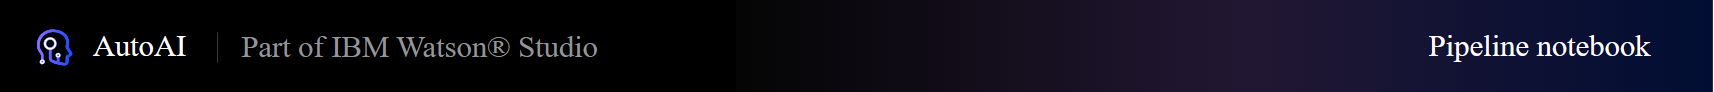

<a id="content"></a>
## Notebook content

This notebook contains a Scikit-learn representation of AutoAI pipeline. This notebook introduces commands for retrieving data, training the model, and testing the model. 

Some familiarity with Python is helpful. This notebook uses Python 3.11 and scikit-learn 1.3.

## Notebook goals

-  Scikit-learn pipeline definition
-  Pipeline training 
-  Pipeline evaluation

## Contents

This notebook contains the following parts:

**[Setup](#Setup)**<br>
&nbsp;&nbsp;[Package installation](#Package-installation)<br>
&nbsp;&nbsp;[AutoAI experiment metadata](#AutoAI-experiment-metadata)<br>
&nbsp;&nbsp;[watsonx.ai connection](#watsonx.ai-connection)<br>
**[Pipeline inspection](#Pipeline-inspection)** <br>
&nbsp;&nbsp;[Read training data](#Read-training-data)<br>
&nbsp;&nbsp;[Create pipeline](#Create-pipeline)<br>
&nbsp;&nbsp;[Train pipeline model](#Train-pipeline-model)<br>
&nbsp;&nbsp;[Test pipeline model](#Test-pipeline-model)<br>
**[Store the model](#Store-the-model)**<br>
**[Summary and next steps](#Summary-and-next-steps)**<br>
**[Copyrights](#Copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm-watsonx-ai,
 - autoai-libs,
 - scikit-learn,
 - snapml


In [ ]:
!pip install ibm-watsonx-ai | tail -n 1
!pip install autoai-libs~=2.0 | tail -n 1
!pip install scikit-learn==1.3.* | tail -n 1
!pip install -U lale~=0.8.3 | tail -n 1
!pip install snapml==1.14.* | tail -n 1

Filter warnings for this notebook.

In [ ]:
import warnings

warnings.filterwarnings('ignore')

<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [ ]:
from ibm_watsonx_ai.helpers import DataConnection
from ibm_watsonx_ai.helpers import ContainerLocation

training_data_references = [
    DataConnection(
        data_asset_id='bb400930-661b-41a6-8ce8-513568e7d5fa'
    ),
]
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/f5f48fc2-d64a-4d1f-b34a-3d55e4e28506/wml_data/aec19f08-d208-4235-a605-070d4bc13ec6/data/automl',
        model_location='auto_ml/f5f48fc2-d64a-4d1f-b34a-3d55e4e28506/wml_data/aec19f08-d208-4235-a605-070d4bc13ec6/data/automl/model.zip',
        training_status='auto_ml/f5f48fc2-d64a-4d1f-b34a-3d55e4e28506/wml_data/aec19f08-d208-4235-a605-070d4bc13ec6/training-status.json'
    )
)

The following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [ ]:
experiment_metadata = dict(
    prediction_type='binary',
    prediction_column='class',
    holdout_size=0.1,
    scoring='accuracy',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=2,
    training_data_references=training_data_references,
    training_result_reference=training_result_reference,
    deployment_url='https://au-syd.ml.cloud.ibm.com',
    project_id='e518f882-8cf7-44d6-ae51-72499b1b3ef0',
    positive_label='normal',
    drop_duplicates=True,
    include_batched_ensemble_estimators=[],
    feature_selector_mode='auto'
)

## Set `n_jobs` parameter to the number of available CPUs

In [ ]:
import os, ast
CPU_NUMBER = 4
if 'RUNTIME_HARDWARE_SPEC' in os.environ:
    CPU_NUMBER = int(ast.literal_eval(os.environ['RUNTIME_HARDWARE_SPEC'])['num_cpu'])

<a id="connection"></a>
## watsonx.ai connection

This cell defines the credentials required to work with the watsonx.ai Runtime.

**Action**: Provide the IBM Cloud apikey, For details, see [documentation](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [ ]:
import getpass

api_key = getpass.getpass("Please enter your api key (press enter): ")

In [ ]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url=experiment_metadata['deployment_url']
)

In [ ]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

if 'space_id' in experiment_metadata:
    client.set.default_space(experiment_metadata['space_id'])
else:
    client.set.default_project(experiment_metadata['project_id'])

training_data_references[0].set_client(client)

<a id="inspection"></a>
# Pipeline inspection

<a id="read"></a>
## Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

**Note**: If reading data results in an error, provide data as Pandas DataFrame object, for example, reading .CSV file with `pandas.read_csv()`.

It may be necessary to use methods for initial data pre-processing like: e.g. `DataFrame.dropna()`, `DataFrame.drop_duplicates()`, `DataFrame.sample()`.


In [ ]:
X_train, X_test, y_train, y_test = training_data_references[0].read(experiment_metadata=experiment_metadata, with_holdout_split=True, use_flight=True)

<a id="preview_model_to_python_code"></a>
## Create pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

#### Import statements.

In [ ]:
from autoai_libs.transformers.exportable import ColumnSelector
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from snapml import SnapDecisionTreeClassifier

#### Pre-processing & Estimator.

In [ ]:
column_selector_0 = ColumnSelector(
    columns_indices_list=[
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40,
    ]
)
numpy_column_selector_0 = NumpyColumnSelector(
    columns=[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str", "char_str", "char_str", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    filling_values=float("nan"), missing_values=[]
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"), float("nan"), float("nan"), 100001, 100001, 100001,
        100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
        100001, 100001, 100001,
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    missing_values=float("nan"),
    sklearn_version_family="1",
    strategy="most_frequent",
)
cat_encoder = CatEncoder(
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="1",
    encoding="ordinal",
    categories="auto",
)
pipeline_0 = make_pipeline(
    column_selector_0,
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
column_selector_1 = ColumnSelector(
    columns_indices_list=[
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40,
    ]
)
numpy_column_selector_1 = NumpyColumnSelector(
    columns=[
        0, 4, 5, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38,
    ]
)
float_str2_float = FloatStr2Float(
    dtypes_list=[
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_int_num",
        "float_int_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_num",
    ],
    missing_values_reference_list=[],
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    filling_values=float("nan"), missing_values=[]
)
num_imputer = NumImputer(missing_values=float("nan"), strategy="median")
opt_standard_scaler = OptStandardScaler(use_scaler_flag=False)
pipeline_1 = make_pipeline(
    column_selector_1,
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 4, 5,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38,
    ],
)
snap_decision_tree_classifier = SnapDecisionTreeClassifier(
    n_jobs=CPU_NUMBER, random_state=33
)


#### Pipeline.

In [ ]:
pipeline = make_pipeline(
    union, numpy_permute_array, snap_decision_tree_classifier
)

<a id="train"></a>
## Train pipeline model


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [ ]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])

<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [ ]:
pipeline.fit(X_train.values, y_train.values.ravel());

<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the generated scorer using the holdout dataset.

In [ ]:
score = scorer(pipeline, X_test.values, y_test.values)
print(score)

In [ ]:
pipeline.predict(X_test.values[:5])

<a id="saving"></a>
## Store the model

In this section you will learn how to store the trained model.

In [ ]:
model_metadata = {
    client.repository.ModelMetaNames.NAME: 'P2 - Pretrained AutoAI pipeline'
}

stored_model_details = client.repository.store_model(model=pipeline, meta_props=model_metadata, experiment_metadata=experiment_metadata)

Inspect the stored model details.

In [ ]:
stored_model_details

<a id="deployment"></a>
## Create online deployment

You can use the commands below to promote the model to space and create online deployment (web service).

<a id="working_spaces"></a>
### Working with spaces

In this section you will specify a deployment space for organizing the assets for deploying and scoring the model. If you do not have an existing space, you can use <a href="https://au-syd.dai.cloud.ibm.com/ml-runtime/dashboard?context=wx">Deployment Spaces Dashboard</a> to create a new space, following these steps:

- Click **New Deployment Space**.
- Create an empty space.
- Select Cloud Object Storage.
- Select watsonx.ai Runtime and press **Create**.
- Copy `space_id` and paste it below.

**Tip**: You can also use the API to prepare the space for your work. Learn more [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Info**: Below cells are `raw` type - in order to run them, change their type to `code` and run them (no need to restart the notebook). You may need to add some additional info (see the **action** below).

**Action**: Assign or update space ID below.


#### Prepare online deployment

#### Test online deployment

<a id="cleanup"></a>
### Deleting deployment
You can delete the existing deployment by calling the `client.deployments.delete(deployment_id)` command.
To list the existing web services, use `client.deployments.list()`.

<a id="summary_and_next_steps"></a>
# Summary and next steps
You successfully completed this notebook!
You learned how to use AutoAI pipeline definition to train the model.
Check out our [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai) for more samples, tutorials, documentation, how-tos, and blog posts.

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2025 IBM. This notebook and its source code are released under the terms of the ILAN License. Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="https://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>

___